In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from typing import Optional, Union, Tuple, Dict, Any, List

In [27]:
# Functions
def compute_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the number and percentage of missing values for each column in a DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame to analyze for missing values.

    Returns:
        pd.DataFrame: A DataFrame containing counts and percentages of missing values for each column.
    """
    
    # Check for missing values in the dataframe
    missing_values = data.isnull().sum()
    missing_values_percentage = round((data.isnull().sum() / len(data)) * 100, 2)

    # Combine the counts and percentages into a dataframe for a clearer view
    missing_values_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage (%)': missing_values_percentage
    }).sort_values(by='Percentage (%)', ascending=False)
    
    # Filter to include only columns where missing value count > 0
    # missing_values_df = missing_values_df[missing_values_df['Missing Values'] > 0].sort_values(by='Percentage (%)', ascending=False)
    missing_values_df = missing_values_df.sort_values(by='Percentage (%)', ascending=False)
    
    return missing_values_df

def not_alphanumeric_columns(data: pd.DataFrame, pattern=r"[^a-zA-Z0-9\s]") -> list:
    """
    Identify columns with non-alphanumeric characters in a DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame to analyze.
        pattern (str, optional): Regular expression pattern to search for. Defaults to non-alphanumeric characters.

    Returns:
        list: A list of column names that contain entries with non-alphanumeric characters.
    """
    
    columns_with_symbols = []
    
    for column in data.columns:
        if data[data[column].astype(str).str.contains(pattern, na=False, regex=True)].shape[0] > 0:
            columns_with_symbols.append(column)
    
    return columns_with_symbols

def not_alphanumeric(data: pd.DataFrame, column: str, pattern=r"[^a-zA-Z0-9\s]") -> pd.Series:
    """
    View entries with non-alphanumeric characters for a specific column in a DataFrame.

    Args:
        data (pd.DataFrame): The DataFrame to analyze.
        column (str): The column in which to search for non-alphanumeric characters.
        pattern (str, optional): Regular expression pattern to search for. Defaults to non-alphanumeric characters.

    Returns:
        pd.Series: A series containing entries from the specified column that match the pattern.
    """
    
    return data[data[column].astype(str).str.contains(pattern, na=False, regex=True)][column]

def outliers_numerical_cols(df: pd.DataFrame) -> None:
    """Visualize outliers in numerical columns using boxplots.

    Args:
        df (pd.DataFrame): Input dataframe.
    """
    numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
    num_cols = 3
    num_rows = (len(numerical_columns) + 2) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for i, col in enumerate(numerical_columns, start=1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(x=df[col].dropna())
        plt.title(col)

    plt.tight_layout()
    plt.show()


def distribution_numerical_cols(df: pd.DataFrame, kde: bool = True) -> None:
    """Visualize distribution of numerical columns using histograms.

    Args:
        df (pd.DataFrame): Input dataframe.
        kde (bool, optional): Whether to plot a KDE (Kernel Density Estimation). Defaults to True.
    """
    numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
    num_cols = 3
    num_rows = (len(numerical_columns) + 2) // num_cols

    plt.figure(figsize=(15, 5 * num_rows))
    for i, col in enumerate(numerical_columns, start=1):
        try:
            plt.subplot(num_rows, num_cols, i)
            sns.histplot(df[col], bins=30, kde=kde)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
        except:
            continue

    plt.tight_layout()
    plt.show()


def outlier_cols(column_data: pd.Series) -> bool:
    """Check if a column has outliers using IQR.

    Args:
        column_data (pd.Series): Column data to check.

    Returns:
        bool: True if outliers exist, False otherwise.
    """
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((column_data < lower_bound) | (column_data > upper_bound)).any()

def analyze_categorical_column(
    dataframe: pd.DataFrame, column_name: str
) -> Tuple[Dict[str, Any], pd.DataFrame, pd.DataFrame, List[str]]:
    """Analyze a categorical column of a given DataFrame.

    Args:
        dataframe (pd.DataFrame): Input dataframe containing the column to be analyzed.
        column_name (str): Name of the categorical column to analyze.

    Returns:
        Tuple[Dict[str, Any], pd.DataFrame, pd.DataFrame, List[str]]: A tuple containing
        analysis results as a dictionary,
        dataframes with the shortest and longest values,
        and a list of non-string columns.
    """
    analysis_results = {}
    non_str_columns = []

    if column_name not in dataframe.columns:
        return f"The column '{column_name}' does not exist in the DataFrame."

    analysis_results["missing_values"] = dataframe[column_name].isnull().sum()
    analysis_results["unique_values"] = dataframe[column_name].nunique()
    analysis_results["total_values"] = dataframe[column_name].count()
    analysis_results["duplicated_values"] = dataframe[column_name].duplicated().sum()
    analysis_results["values_with_whitespace"] = (
        dataframe[column_name].str.strip().ne(dataframe[column_name]).sum()
    )
    analysis_results["values_with_unusual_chars"] = (
        dataframe[column_name]
        .apply(lambda x: any(ord(char) < 32 or ord(char) > 126 for char in str(x)))
        .sum()
    )

    value_lengths = dataframe[column_name].str.len()
    analysis_results["shortest_value_length"] = value_lengths.min()
    analysis_results["longest_value_length"] = value_lengths.max()
    analysis_results["average_value_length"] = value_lengths.mean()

    shortest_value = dataframe[
        dataframe[column_name].str.len() == analysis_results["shortest_value_length"]
    ]
    longest_value = dataframe[
        dataframe[column_name].str.len() == analysis_results["longest_value_length"]
    ]

    return analysis_results, shortest_value, longest_value

def column_max_lengths(dataframe: pd.DataFrame, categorical_columns: List[str]) -> None:
    """
    Display the maximum string lengths of specified columns in a given dataframe.
    
    Args:
        dataframe (pd.DataFrame): The dataframe containing the columns to be analyzed.
        columns (List[str]): List of column names whose maximum string lengths are to be displayed.
        
    Returns:
        None: The function prints the results and does not return any value.
    """
    
    print("Column Name".ljust(30), "Max Length".ljust(10))
    print("-" * 40)
    for column in categorical_columns:
        max_length = dataframe[column].str.len().max()
        print(f"{column.ljust(30)} {str(max_length).ljust(10)}")

# raw_titles

In [28]:
data = pd.read_csv("raw_titles_df.csv")
df = pd.DataFrame(data)

In [38]:
df.dtypes

id                      string[python]
title                   string[python]
type                    string[python]
release_year                     int64
age_certification       string[python]
runtime                          int64
genres                  string[python]
production_countries    string[python]
seasons                          int64
imdb_id                 string[python]
imdb_score                     float64
imdb_votes                       int64
title_id                         int64
dtype: object

In [37]:
"""Mapping for column names and types."""
columns_dict = {
                'id': 'string',
                'title': 'string',
                'type': 'string',
                'release_year': 'int', # DATE YEAR? OR INT
                'age_certification': 'string',
                'runtime': 'int', 
                'genres': 'string', # Or list
                'production_countries': 'string',# Or list
                'seasons': 'int',
                'imdb_id': 'string',
                'imdb_score': 'float64',
                'imdb_votes': 'int'
                }

errors = []

for column, dtype in columns_dict.items():
    try:
        df[column] = df[column].astype(dtype)
    except ValueError:
        errors.append(f'Column {column} dtype change failed!')
        
# df['price'] = pd.to_numeric(df['price'], errors='coerce')
# df['pages'] = pd.to_numeric(df['pages'], errors='coerce').astype('Int64')

In [15]:
df.head(5)

,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,title_id
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,TV-MA,48,documentation,US,1,<NA>,6.6,2279,1
1,tm84618,Taxi Driver,MOVIE,1976,R,113,"crime, drama",US,0,tt0075314,8.3,795222,2
2,tm127384,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"comedy, fantasy",GB,0,tt0071853,8.2,530877,3
3,tm70993,Life of Brian,MOVIE,1979,R,94,comedy,GB,0,tt0079470,8.0,392419,4
4,tm190788,The Exorcist,MOVIE,1973,R,133,horror,US,0,tt0070047,8.1,391942,5


In [39]:
not_alphanumeric_columns(df)

['title',
 'age_certification',
 'genres',
 'production_countries',
 'imdb_id',
 'imdb_score']

In [40]:
not_alphanumeric(df, 'imdb_score').head(10)

0    6.6
1    8.3
2    8.2
3    8.0
4    8.1
5    8.8
6    7.7
7    7.8
8    5.8
9    7.7
Name: imdb_score, dtype: float64

In [41]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
release_year,5805.0,2016.013609,7.325502,1945.0,2015.0,2018.0,2020.0,2022.0
runtime,5805.0,77.655469,39.467866,0.0,44.0,84.0,105.0,251.0
seasons,5805.0,0.763652,1.876334,0.0,0.0,0.0,1.0,42.0
imdb_score,5805.0,6.539432,1.107660,1.5,5.9,6.6,7.3,9.6
imdb_votes,5805.0,21449.060810,83223.547434,5.0,608.0,2279.0,8221.0,2268288.0
title_id,5805.0,2903.689061,1676.274645,1.0,1452.0,2904.0,4355.0,5806.0


In [42]:
# Best rated movies
df[df['type'] == 'MOVIE'].sort_values(by='imdb_score', ascending=False).head(5)


,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,title_id
2813,tm432327,C/o Kancharapalem,MOVIE,2018,PG,152,drama,IN,0,tt7391996,9.0,6562,2815
3351,tm853783,David Attenborough: A Life on Our Planet,MOVIE,2020,PG,83,documentation,GB,0,tt11989890,9.0,31180,3353
25,tm76557,No Longer Kids,MOVIE,1979,<NA>,235,"comedy, drama",EG,0,tt8312792,9.0,943,26
876,tm166740,Chhota Bheem & Krishna in Mayanagari,MOVIE,2011,G,66,"animation, action, fantasy",IN,0,tt16235600,9.0,5,877
260,tm92641,Inception,MOVIE,2010,PG-13,148,"scifi, music, thriller, action","GB, US",0,tt1375666,8.8,2268288,261


In [43]:
df.dtypes

id                      string[python]
title                   string[python]
type                    string[python]
release_year                     int64
age_certification       string[python]
runtime                          int64
genres                  string[python]
production_countries    string[python]
seasons                          int64
imdb_id                 string[python]
imdb_score                     float64
imdb_votes                       int64
title_id                         int64
dtype: object

In [47]:
unique_non_string_values = df.loc[df['genres'].apply(lambda x: not isinstance(x, str)), 'genres'].unique()

unique_non_string_values

<StringArray>
[<NA>]
Length: 1, dtype: string

In [49]:
df.isna().sum()

id                         0
title                      0
type                       0
release_year               0
age_certification       2609
runtime                    0
genres                    67
production_countries     232
seasons                    0
imdb_id                  444
imdb_score                 0
imdb_votes                 0
title_id                   0
dtype: int64

In [52]:
df[df['age_certification'].isna()].head(5)

,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,title_id
11,tm44204,The Guns of Navarone,MOVIE,1961,<NA>,158,"war, action, drama","US, GB",0,tt0054953,7.5,50150,12
15,tm16479,White Christmas,MOVIE,1954,<NA>,115,"romance, comedy, music",US,0,tt0047673,7.5,42373,16
16,tm135083,Cairo Station,MOVIE,1958,<NA>,77,"drama, crime, comedy",EG,0,tt0051390,7.5,4385,17
17,tm14491,The Queen,MOVIE,1968,<NA>,68,documentation,US,0,tt0183686,7.2,1117,18
20,tm27298,Saladin the Victorious,MOVIE,1963,<NA>,186,"drama, war, action, history, romance",EG,0,tt0057357,7.6,2470,21


In [53]:
df[df['genres'].isna()].head(5)

,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,title_id
182,ts18465,Dale's Supermarket Sweep,SHOW,1993,TV-G,21,<NA>,GB,8,tt0962853,7.1,39,183
242,tm255589,One Last Shot,MOVIE,1998,<NA>,30,<NA>,<NA>,0,<NA>,6.6,2279,243
678,tm341561,Like Twenty Impossibles,MOVIE,2003,<NA>,16,<NA>,PS,0,<NA>,6.6,2279,679
686,tm89054,Osuofia in London 2,MOVIE,2004,<NA>,72,<NA>,XX,0,<NA>,6.6,2279,687
691,tm404676,To and from New York,MOVIE,2006,<NA>,82,<NA>,US,0,<NA>,6.6,2279,692


In [45]:
all_genres = df['genres'].str.split(", ").sum()
# all_genres = df['genres'].str.strip("[]").str.replace("'", "").str.split(", ").sum()

TypeError: can only concatenate list (not "int") to list

In [21]:
# Extract genres from the 'genres' column
# all_genres = df['genres'].str.strip("[]").str.replace("'", "").str.split(", ").sum()
all_genres = df['genres'].str.split(", ").sum()

# Convert the list of genres into a Series and count occurrences
genre_counts = pd.Series(all_genres).value_counts()

# Plot the top 10 genres
plt.figure(figsize=(15, 7))
sns.barplot(y=genre_counts.index[:10], x=genre_counts.values[:10], palette='magma')
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.show()


TypeError: can only concatenate list (not "int") to list

In [ ]:
numerical_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()
# categorical_cols = ['title', 'series', 'bookFormat', 'edition', 'publisher']
categorical_cols = df.select_dtypes(include=['string', 'object']).columns.tolist()
numerical_cols, categorical_cols

(['release_year',
  'runtime',
  'seasons',
  'imdb_score',
  'imdb_votes',
  'title_id'],
 ['id',
  'title',
  'type',
  'age_certification',
  'genres',
  'production_countries',
  'imdb_id'])

In [ ]:
desc_stats = df[numerical_cols].describe().T
desc_stats["mode"] = df[numerical_cols].mode().iloc[0]
desc_stats

,count,mean,std,min,25%,50%,75%,max,mode
release_year,5805.0,2016.013609,7.325502,1945.0,2015.0,2018.0,2020.0,2022.0,2019.0
runtime,5805.0,77.655469,39.467866,0.0,44.0,84.0,105.0,251.0,24.0
seasons,5805.0,0.763652,1.876334,0.0,0.0,0.0,1.0,42.0,0.0
imdb_score,5805.0,6.539432,1.107660,1.5,5.9,6.6,7.3,9.6,6.6
imdb_votes,5805.0,21449.060810,83223.547434,5.0,608.0,2279.0,8221.0,2268288.0,2279.0
title_id,5805.0,2903.689061,1676.274645,1.0,1452.0,2904.0,4355.0,5806.0,1.0


In [ ]:
"""Create analyses dictionary to view for cateogrical columns. """
analysis_results_dict = {}
non_str_columns = []

for column in df.columns:
    try:
        results, shortest, longest = analyze_categorical_column(df, column)
        analysis_results_dict[column] = {
            "analysis_results": results,
            "shortest_value": shortest,
            "longest_value": longest
        }
    except Exception as e:
        non_str_columns.append(column)

non_str_columns

['release_year', 'runtime', 'seasons', 'imdb_score', 'imdb_votes', 'title_id']

In [ ]:
new_col = 'type'
analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 2,
 'total_values': 5805,
 'duplicated_values': 5803,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 0,
 'shortest_value_length': 4,
 'longest_value_length': 5,
 'average_value_length': 4.647372954349699}

In [ ]:
new_col = 'title'
analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 5751,
 'total_values': 5805,
 'duplicated_values': 54,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 117,
 'shortest_value_length': 1,
 'longest_value_length': 104,
 'average_value_length': 17.85460809646856}

In [ ]:
new_col = 'age_certification'
analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 12,
 'total_values': 5805,
 'duplicated_values': 5793,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 0,
 'shortest_value_length': 1,
 'longest_value_length': 5,
 'average_value_length': 3.905770887166236}

In [ ]:
new_col = 'production_countries'
analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 449,
 'total_values': 5805,
 'duplicated_values': 5356,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 0,
 'shortest_value_length': 0,
 'longest_value_length': 26,
 'average_value_length': 2.5552110249784667}

In [ ]:
new_col = 'genres'
analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 1626,
 'total_values': 5805,
 'duplicated_values': 4179,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 0,
 'shortest_value_length': 0,
 'longest_value_length': 76,
 'average_value_length': 19.550043066322136}

In [ ]:
new_col = 'imdb_id'
analysis_results_dict[new_col]['analysis_results']

{'missing_values': 0,
 'unique_values': 5362,
 'total_values': 5805,
 'duplicated_values': 443,
 'values_with_whitespace': 0,
 'values_with_unusual_chars': 0,
 'shortest_value_length': 4,
 'longest_value_length': 10,
 'average_value_length': 8.900258397932816}

In [ ]:
column_max_lengths(df, categorical_cols)

Column Name                    Max Length
----------------------------------------
id                             9         
title                          104       
type                           5         
age_certification              5         
genres                         76        
production_countries           26        
imdb_id                        10        


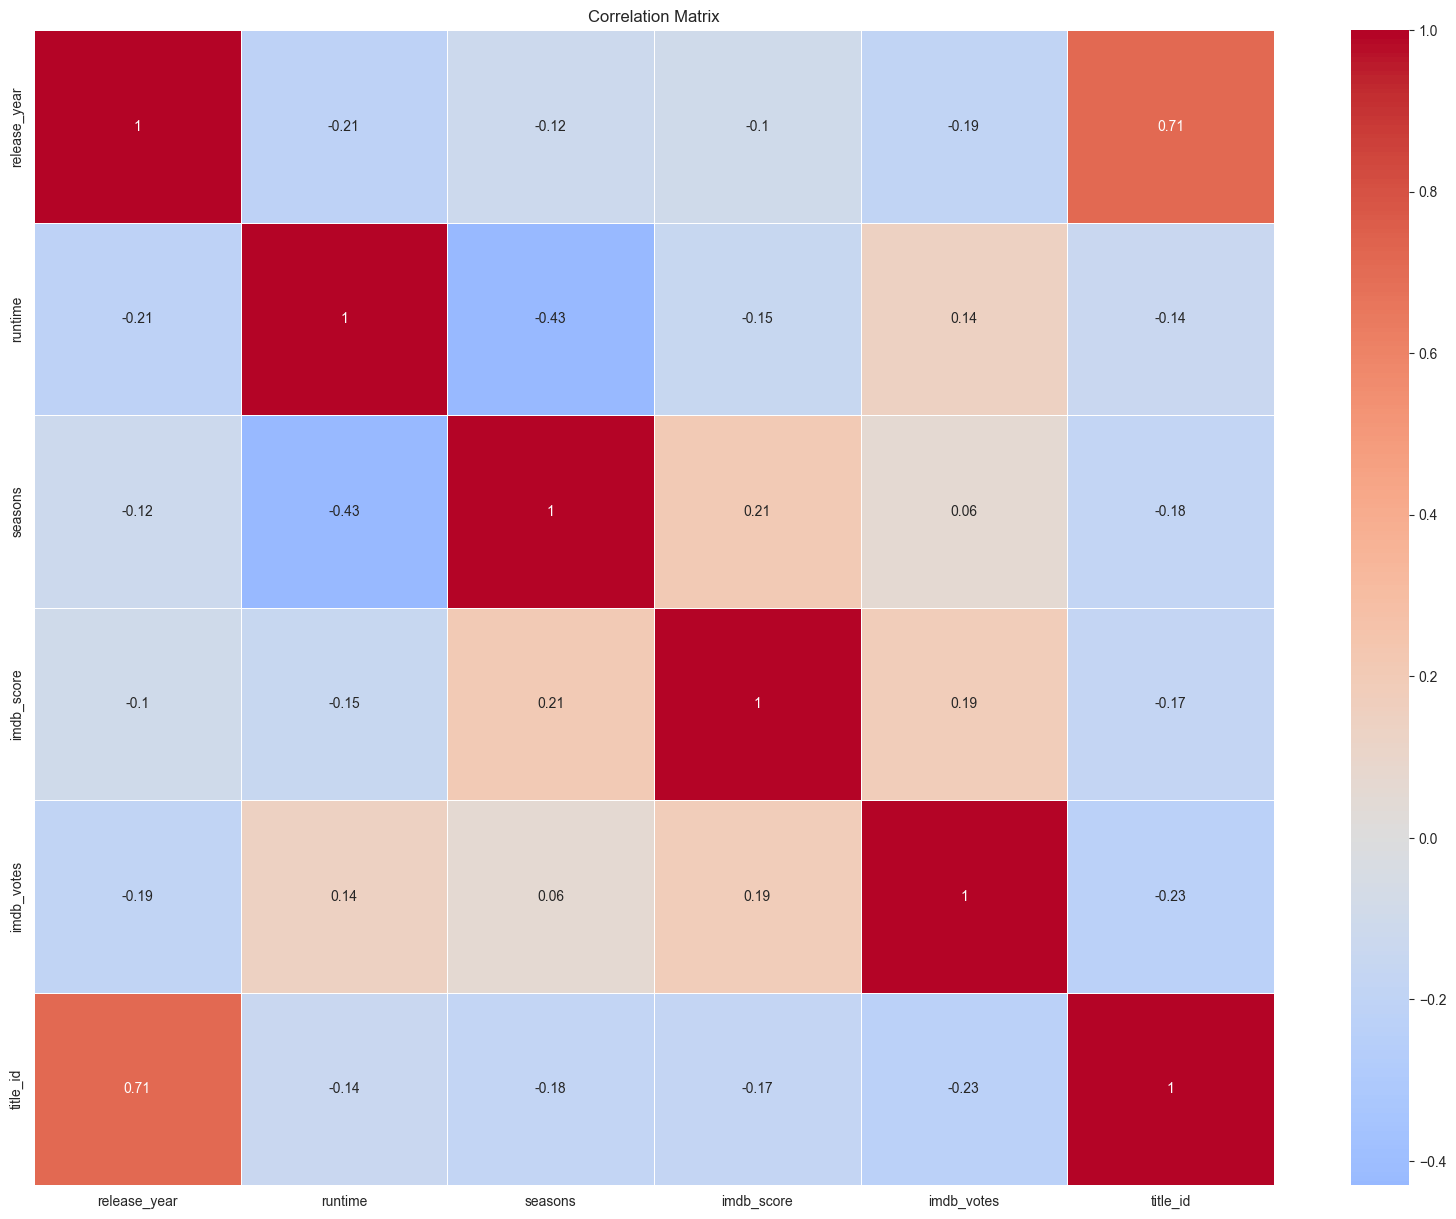

In [ ]:
"""
Computing correlation matrix between numerical columns and plotting it 
for ease of visualization. Some columns are highly correlated with one another, 
which makes sense because a votes and ratings are associated.
"""
corr_matrix = df[numerical_cols].corr().round(2)

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=.5)
plt.title("Correlation Matrix")
plt.show()


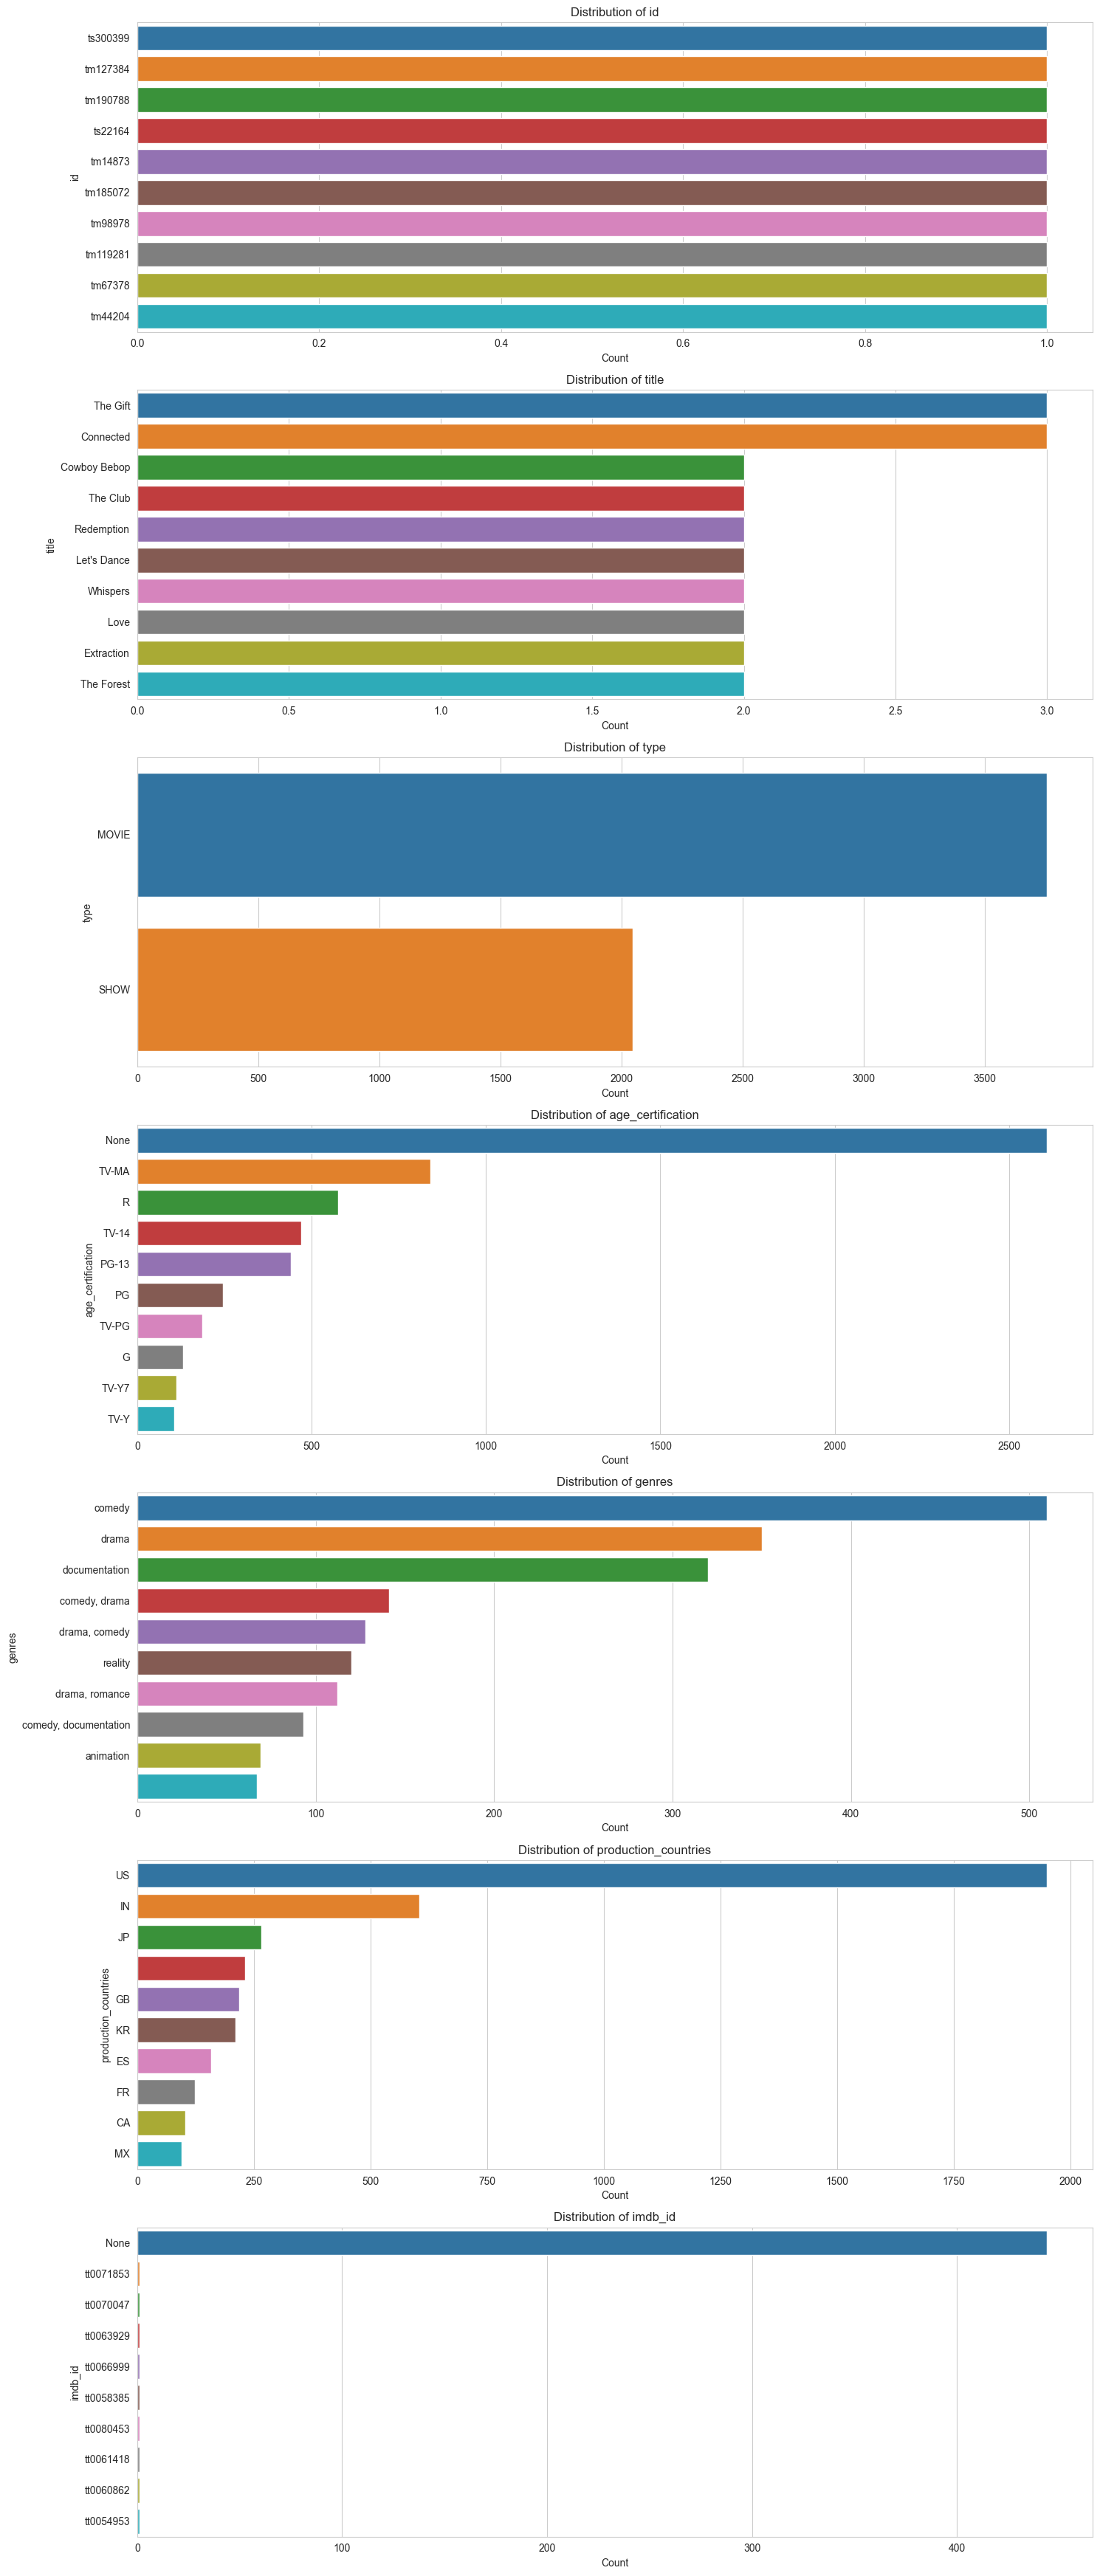

In [ ]:
""" Plotting categorical Columns, first 10 values only."""
plt.figure(figsize=(15, 5 * len(categorical_cols)))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.countplot(data=df, y=col, order=df[col].value_counts().index[:10])
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

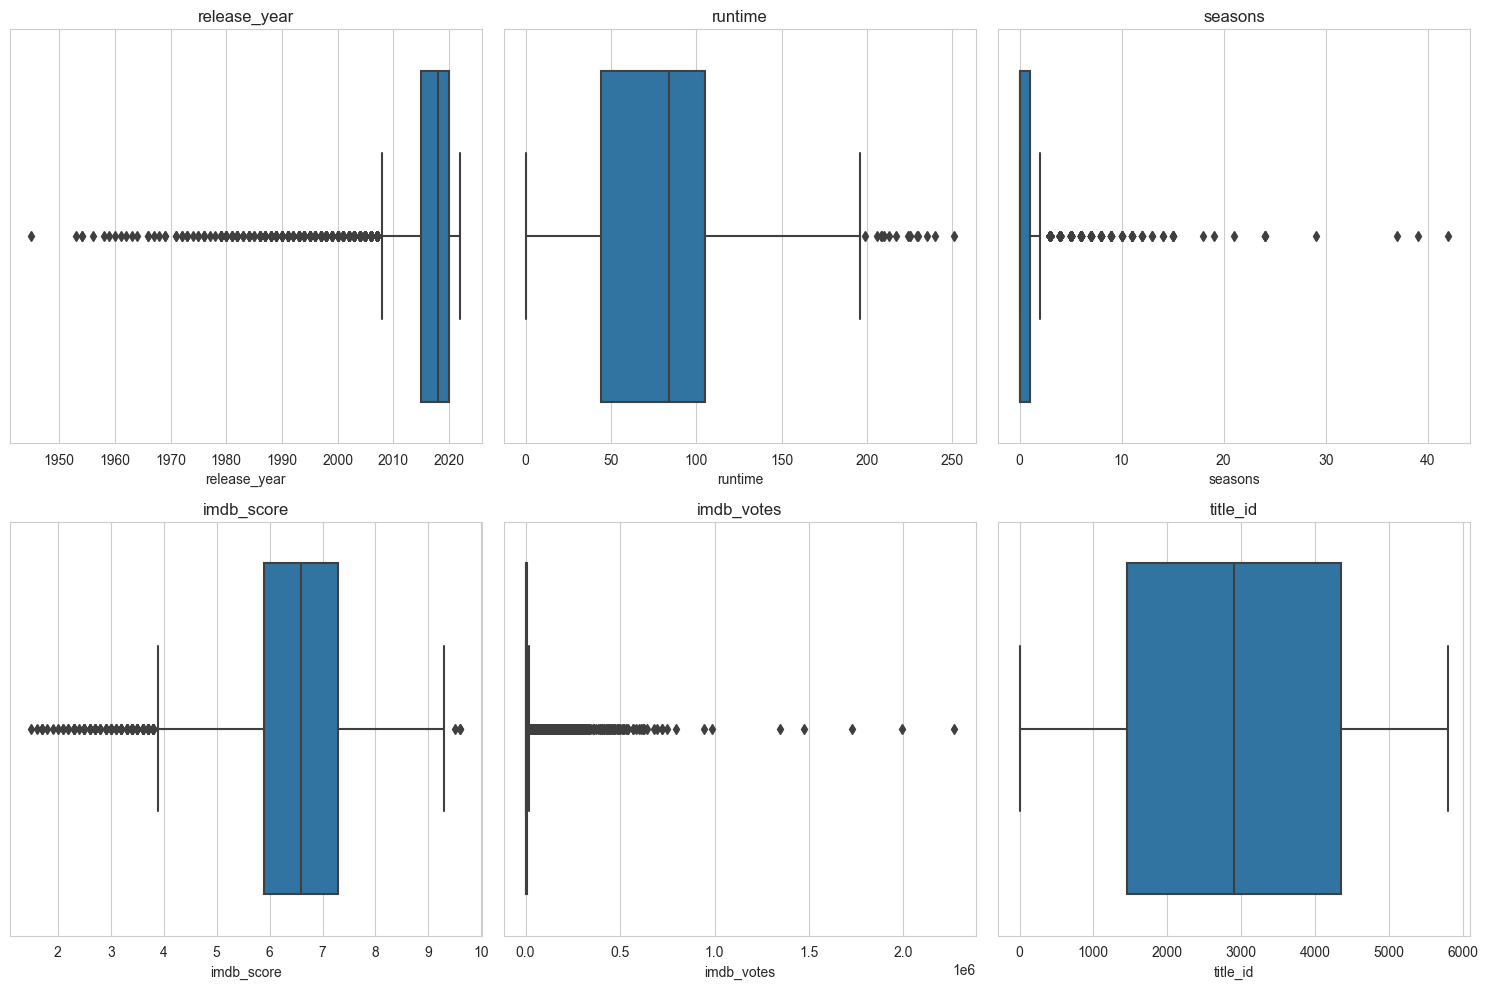

In [ ]:
"""Graphical investigation of numerical columns for outliers."""
outliers_numerical_cols(df)

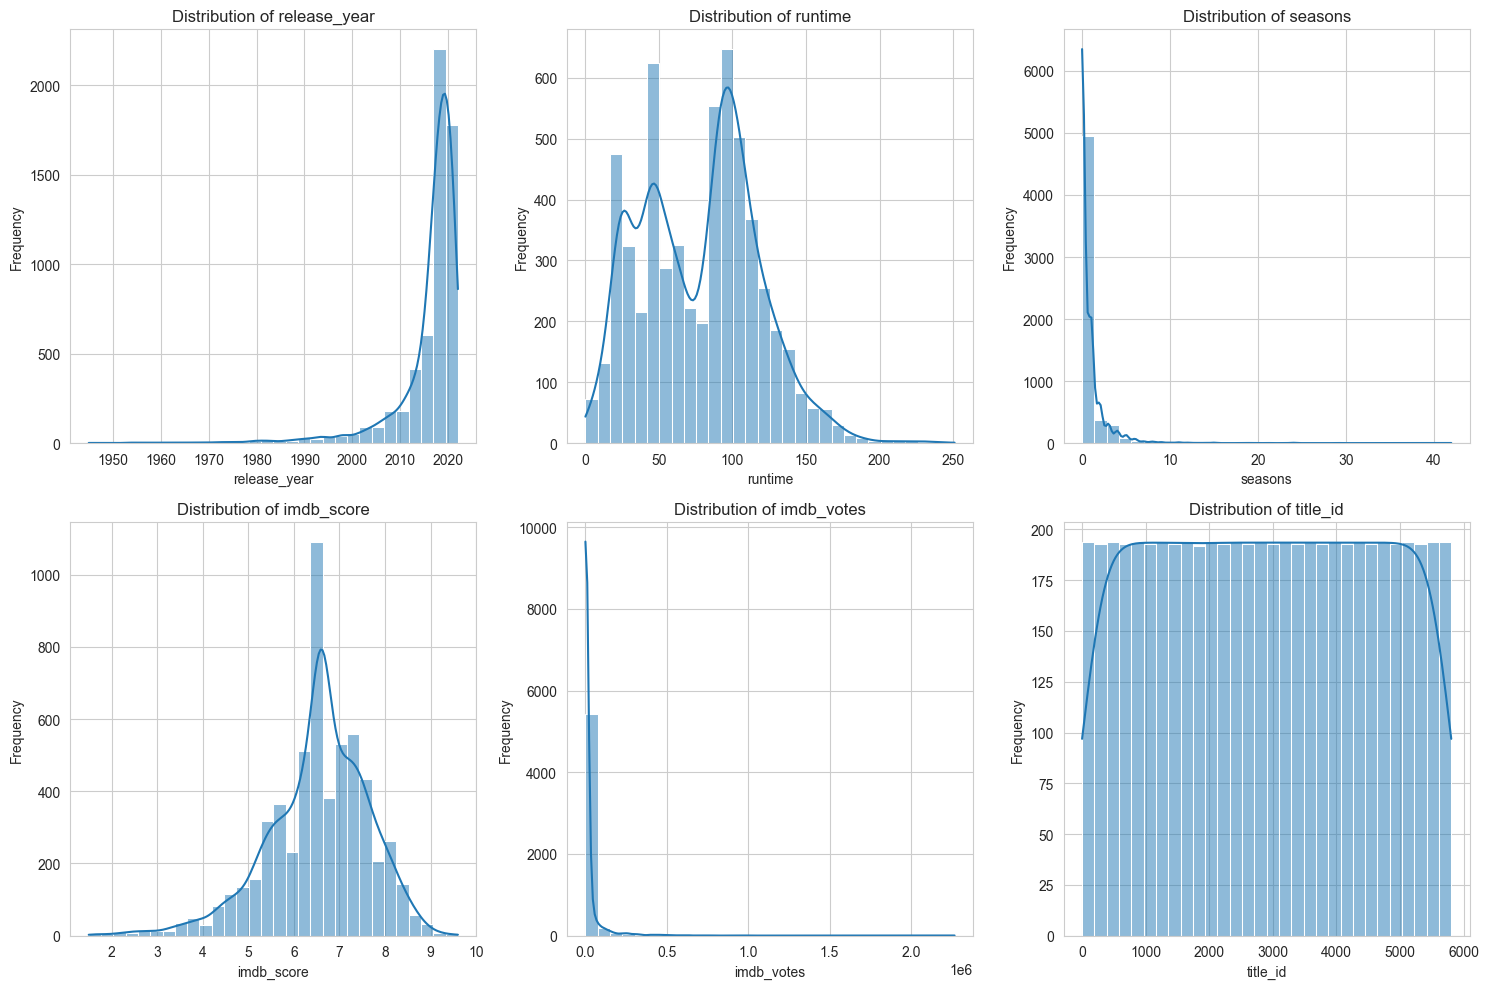

In [ ]:
"""View distribution of numerical columns."""
distribution_numerical_cols(df)

In [ ]:
"""The dataset predominantly contains titles released from the early 2000s onwards, with a peak around the 2010s. There are fewer titles from the mid-20th century, and the number increases gradually from the 1980s.
"""
